In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import kstest, expon, combine_pvalues
from IPython.display import display, Markdown

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Turnover Rate Test

In [3]:
def test_turnover_time(
    algorithm, speciation=0.001, seeds=[42], sample=1.0, size=100,
):
    total_pvalues = []
    total_turnovers = []
    
    for seed in seeds:
        # Configure the simulation
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: NonSpatial(
                area: ({size}, {size}),
                deme: {size},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalTurnover(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, size=size,
        ).split()).replace(",)", ")").replace(",]", "]")
        
        # Run the simulation
        turnovers_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the speciation times
        turnovers = []
        with turnovers_io:
            reader = csv.reader(turnovers_io)
            next(reader)

            for row in reader:
                turnovers.append(float(row[0]))
        turnovers = np.array(turnovers)
    
        # Calculate in the dispersal locations
        gof = kstest(turnovers, expon(loc=0.0, scale=2.0).cdf)
        
        total_pvalues.append(gof.pvalue)
        total_turnovers.append(turnovers)
    
    gof_statistic, gof_pvalue = combine_pvalues(total_pvalues)
    
    if gof_pvalue <= 0.01 or gof_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.05 or gof_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.1 or gof_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Fisher’s combined KS test:"))
    display(Markdown(f"\n* p-value: {gof_pvalue}\n* statistic: {gof_statistic}"))
    
    display(Markdown("#### Turnover histograms:"))
    
    turnovers = np.concatenate(total_turnovers)
    
    # Draw the turnover time histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    x = np.linspace(np.min(turnovers), np.max(turnovers), 1000)
    loc, scale = expon.fit(turnovers)
    
    ax1.set_title(f"Individual turnover times PDF")
    ax1.set_xlabel("turnover time")
    ax1.set_ylabel("pdf")
    ax1.plot(x, expon.pdf(x, 0.0, 2.0), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda=0.5")
    ax1.hist(turnovers, bins = 1000, density=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax1.legend()
    
    ax2.set_title(f"Individual turnover times CDF")
    ax2.set_xlabel("turnover time")
    ax2.set_ylabel("cdf")
    ax2.plot(x, expon.cdf(x, 0.0, 2.0), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda=0.5")
    ax2.hist(turnovers, bins = 1000, density=True, cumulative=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax2.legend()

    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:orange'>*Classical*</span>

#### Fisher’s combined KS test:


* p-value: 0.08897372581663382
* statistic: 28.938683806823875

#### Turnover histograms:

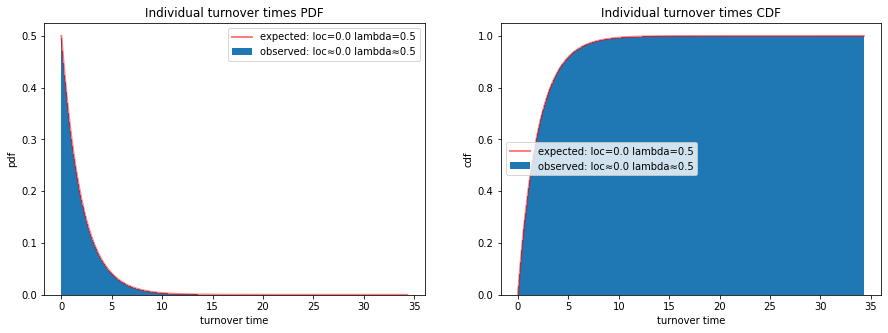

#### Parameters:
* seeds: [ 6232108458950764573 11858642973332759928 15328693990019866738
  9867785756707371921 11973548716122055998 17632805607135229133
 17182890070231802101  5120436234576726676  3006177158922281512
  2423522153592234927]

#### Configuration:
```rust
(speciation:0.001,seed:2423522153592234927,sample:0.1,algorithm:Classical(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:green'>Gillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.6864208974638504
* statistic: 16.480222771956036

#### Turnover histograms:

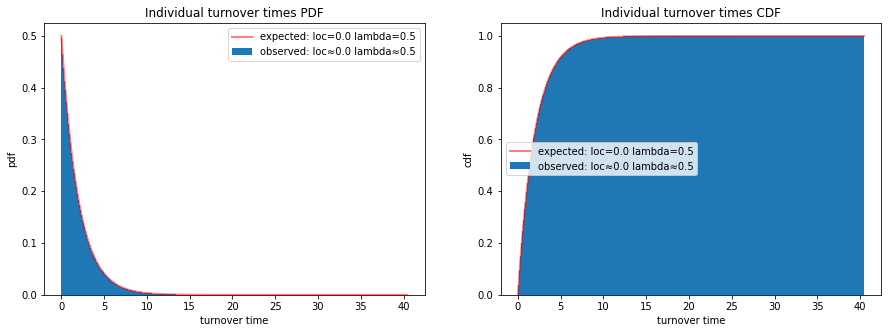

#### Parameters:
* seeds: [ 5478637805773894129 10059009415726246058 12126046735320116506
 12910907429005155287  4567806953645225949 15634753482794670816
 12755129979108548722   342346696825696293  6924564084251633487
  7904956018756220829]

#### Configuration:
```rust
(speciation:0.001,seed:7904956018756220829,sample:0.1,algorithm:Gillespie(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.4435706916525323
* statistic: 20.23091574370118

#### Turnover histograms:

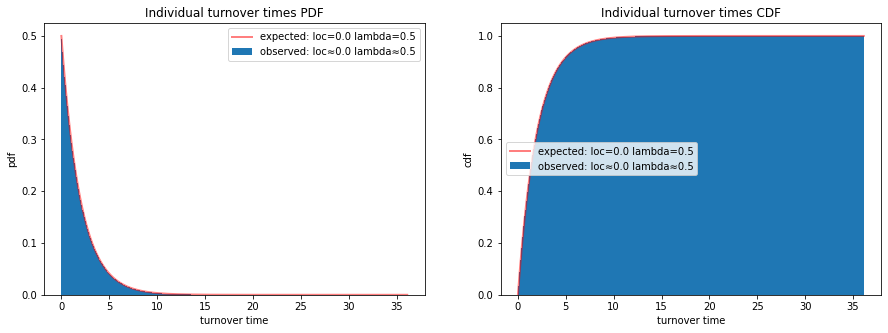

#### Parameters:
* seeds: [13977710435317984092 17776300106708684853  2941254200093122103
  7741641344286596134 10133513132151389719  3874108308432719267
 13737507592676705489  8860155978981161191 13234785754500314996
 16935489055314680373]

#### Configuration:
```rust
(speciation:0.001,seed:16935489055314680373,sample:0.1,algorithm:SkippingGillespie(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:green'>Independent</span>

#### Fisher’s combined KS test:


* p-value: 0.2819697961106689
* statistic: 23.140058974134668

#### Turnover histograms:

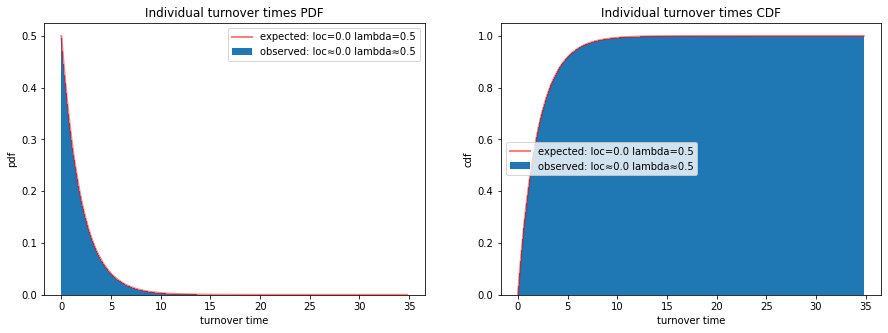

#### Parameters:
* seeds: [11196045581430887717 14820349877511089317  5402599701457773514
 10373595187971893951  5309563398762244640 15161447305022907453
  2439967004386918776 14245971213596204571  2791623499519569123
 12605279402989586010]

#### Configuration:
```rust
(speciation:0.001,seed:12605279402989586010,sample:0.1,algorithm:Independent(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=10)
    
    test_turnover_time(algorithm, speciation=0.001, seeds=seeds, sample=0.1, size=100)